# AI Weather CIRA-Generated Forecasts

Example code to plot a CIRA-Generated forecast from graphcast.

* <https://aiweather.cira.colostate.edu/>
* see class slides for where to access the data on AWS and/or the class google drive resources/data directory

## Environment
```
conda create --name env-ats780a8 python=3.10
conda activate env-ats780a8
conda install -c conda-forge xarray netCDF4 cartopy
pip install ipykernel
```

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import pickle
import numpy as np

In [2]:
ds_dict = {}
var = "t2"

# Change the path to your data here
DATA_DIR = "/Users/eabarnes/GoogleDrive/WORK/TEACHING/ATS780A8/shared/resources/data/"
filename = DATA_DIR + 'FOUR_v200_GFS_2024092400_f000_f240_06.nc'
ds_dict["FOUR"] = xr.open_dataset(filename)

filename = DATA_DIR + 'GRAP_v100_GFS_2024092400_f000_f240_06.nc'
ds_dict["GRAP"] = xr.open_dataset(filename)

ds_dict["GRAP"]

<xarray.Dataset> Size: 14GB
Dimensions:    (time: 41, longitude: 1440, latitude: 721, level: 13)
Coordinates:
  * time       (time) datetime64[ns] 328B 2024-09-24 ... 2024-10-04
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * level      (level) int32 52B 1000 925 850 700 600 500 ... 250 200 150 100 50
Data variables:
    u10        (time, latitude, longitude) float32 170MB ...
    v10        (time, latitude, longitude) float32 170MB ...
    t2         (time, latitude, longitude) float32 170MB ...
    msl        (time, latitude, longitude) float32 170MB ...
    t          (time, level, latitude, longitude) float32 2GB ...
    u          (time, level, latitude, longitude) float32 2GB ...
    v          (time, level, latitude, longitude) float32 2GB ...
    z          (time, level, latitude, longitude) float32 2GB ...
    q          (time, level, latitude, longitude) float32 2GB ...
    w          (time, level, latitude, longitude) float32 2GB ...
    apcp       (time, latitude, longitude) float32 170MB ...
Attributes:
    Conventions:           CF-1.8
    version:               1_2023-10-14
    model_name:            GraphCast
    model_version:         v1
    initialization_model:  GFS
    initialization_time:   2024-09-24T00:00:00
    first_forecast_hour:   0
    last_forecast_hour:    240
    forecast_hour_step:    6
    creation_time:         2024-09-24T04:06:33

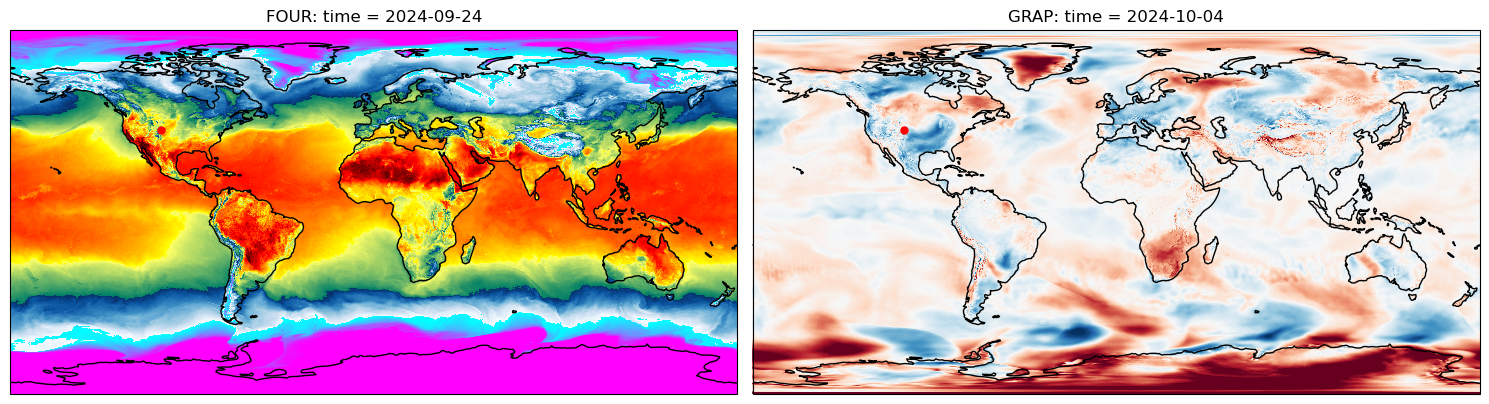

In [3]:
# temperature colormap from pickle
fp = open('sfc_temp_cmap.pkl', 'rb')
sfc_temp_cmap = pickle.load(fp)
fp.close()

# create 500avo colormap
colors1 = plt.cm.YlOrRd(np.linspace(0, 1, 36))
colors2 = plt.cm.BuPu(np.linspace(0.5, 0.75, 8))
colors_500avo = np.vstack((colors2, (1, 1, 1, 1), colors1))
colors_500avo = plt.cm.colors.ListedColormap(np.vstack((colors2, (1, 1, 1, 1), colors1)))

# Define the target latitude and longitude
target_lat = 40.5853
target_lon = 360-105.0844

# Plot and compare the models
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(15, 5))
fig = plt.figure(figsize=(15, 5))

for i, model in enumerate(ds_dict.keys()):
    ax = plt.subplot(1, len(ds_dict), i + 1, projection=ccrs.PlateCarree())

    # Plot the temperature and/or temperature difference
    if model == "FOUR":
        img = ds_dict[model][var][0,:,:].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=sfc_temp_cmap)
        img.set_clim(260, 310)
    else:
        da = ds_dict[model][var][-1,:,:] - ds_dict["FOUR"][var][-1,:,:]
        img = da.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r")
        img.set_clim(-10, 10)

    # Plot the target point
    ax.plot(target_lon, target_lat, 'ro', markersize=5, transform=ccrs.PlateCarree())

    # Add coastlines and gridlines
    ax.coastlines()

    # Remove the colorbar
    img.colorbar.remove()

    # Modify the title
    current_title = ax.get_title()
    ax.set_title(f"{model}: {current_title}")

plt.tight_layout()
plt.show()

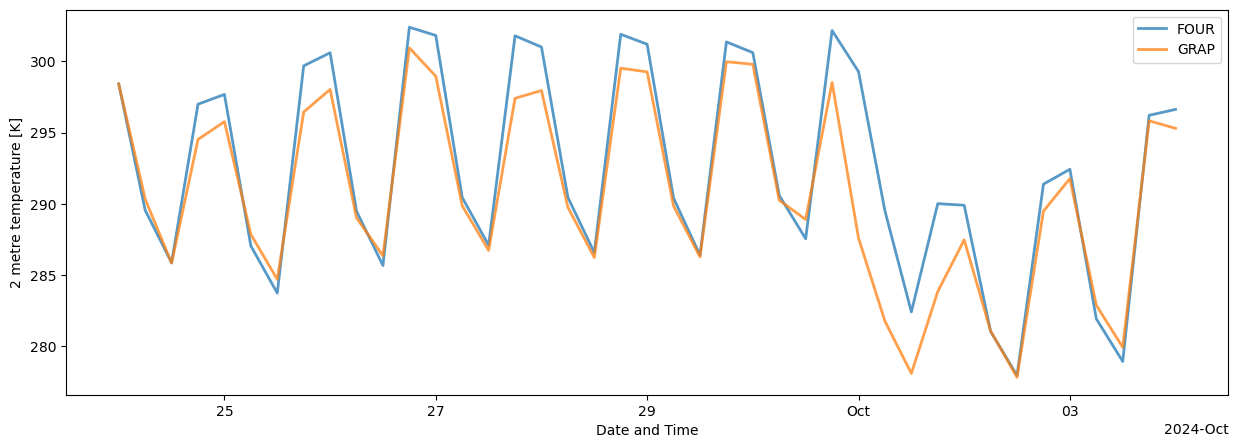

In [4]:
# Compare forecasts at the target point for all AI models
plt.figure(figsize=(15, 5))
for model in ds_dict:
    nearest_point = ds_dict[model][var].sel(latitude=target_lat, longitude=target_lon, method='nearest')
    nearest_point.plot(label=model, alpha=.75, linewidth=2)

# Modify the title
plt.title("")
plt.legend()